## Oxford flower classification (Machine learning)

In [1]:
# Basic libs for working with data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
import scipy as sci
import os
import cv2
import warnings
from PIL import Image

# Suppress all warnings
warnings.filterwarnings('ignore')

# Remove warning
warnings.simplefilter('ignore')


# Set option of DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.width', 100)

# Set theme for plotting
sns.set_theme(style='darkgrid', 
              palette='coolwarm', 
              rc={'figure.figsize' :(15,10)})

# ? Display Multi-output
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"



## Dataset loading

### *Load from local*

In [2]:
import os
from PIL import Image
import pandas as pd

def get_labeled_image_stats(directory):
    data = []

    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    mode = img.mode
                    fmt = img.format
                    aspect_ratio = round(width / height, 2)
                    size_bytes = os.path.getsize(img_path)
                    channels = len(img.getbands())
                    is_grayscale = (mode == "L" or channels == 1)

                data.append({
                    "file_name": img_name,
                    "file_path": img_path,
                    "width": width,
                    "height": height,
                    "aspect_ratio": aspect_ratio,
                    "size_bytes": size_bytes,
                    "mode": mode,
                    "channels": channels,
                    "is_grayscale": is_grayscale,
                    "format": fmt,
                    "class": class_name
                })
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

    return pd.DataFrame(data)



# For labeled data
train_stats_df = get_labeled_image_stats("data/train")
valid_stats_df = get_labeled_image_stats("data/valid")

In [3]:
train_stats_df[["width",	"height"]]

,width,height
0,523,500
1,666,500
2,750,500
3,595,500
4,626,500
...,...,...
6547,655,500
6548,673,500
6549,655,500
6550,667,500


In [4]:
valid_stats_df

,file_name,file_path,width,height,aspect_ratio,size_bytes,mode,channels,is_grayscale,format,class
0,image_06739.jpg,data/valid/1/image_06739.jpg,500,628,0.80,35594,RGB,3,False,JPEG,1
1,image_06749.jpg,data/valid/1/image_06749.jpg,500,750,0.67,54709,RGB,3,False,JPEG,1
2,image_06755.jpg,data/valid/1/image_06755.jpg,624,500,1.25,53676,RGB,3,False,JPEG,1
3,image_06756.jpg,data/valid/1/image_06756.jpg,666,500,1.33,22325,RGB,3,False,JPEG,1
4,image_06758.jpg,data/valid/1/image_06758.jpg,500,750,0.67,58887,RGB,3,False,JPEG,1
...,...,...,...,...,...,...,...,...,...,...,...
813,image_07862.jpg,data/valid/99/image_07862.jpg,500,587,0.85,35622,RGB,3,False,JPEG,99
814,image_07869.jpg,data/valid/99/image_07869.jpg,512,500,1.02,73651,RGB,3,False,JPEG,99
815,image_07873.jpg,data/valid/99/image_07873.jpg,501,596,0.84,43943,RGB,3,False,JPEG,99
816,image_07875.jpg,data/valid/99/image_07875.jpg,667,500,1.33,45849,RGB,3,False,JPEG,99


In [5]:
def get_unlabeled_image_stats(directory):
    """
    Extract basic image statistics from an unlabeled dataset directory.

    Parameters:
        directory (str): Path to the unlabeled dataset directory (e.g., test)

    Returns:
        pd.DataFrame: DataFrame containing metadata for each image
    """
    data = []

    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                mode = img.mode
                fmt = img.format
            data.append({
                "file_name": img_name,
                "file_path": img_path,
                "width": width,
                "height": height,
                "mode": mode,
                "format": fmt
            })
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    return pd.DataFrame(data)


# For test data
test_stats_df = get_unlabeled_image_stats("data/test")

In [6]:
test_stats_df

,file_name,file_path,width,height,mode,format
0,image_03041.jpg,data/test/image_03041.jpg,667,500,RGB,JPEG
1,image_07938.jpg,data/test/image_07938.jpg,750,500,RGB,JPEG
2,image_07939.jpg,data/test/image_07939.jpg,667,500,RGB,JPEG
3,image_07949.jpg,data/test/image_07949.jpg,506,500,RGB,JPEG
4,image_07952.jpg,data/test/image_07952.jpg,500,567,RGB,JPEG
...,...,...,...,...,...,...
814,image_07896.jpg,data/test/image_07896.jpg,603,500,RGB,JPEG
815,image_07897.jpg,data/test/image_07897.jpg,667,500,RGB,JPEG
816,image_07899.jpg,data/test/image_07899.jpg,501,500,RGB,JPEG
817,image_07902.jpg,data/test/image_07902.jpg,667,500,RGB,JPEG


## Exploratory Data Analysis

### *Width and Height Distribution*

[✓] Plot saved to ref_plot/


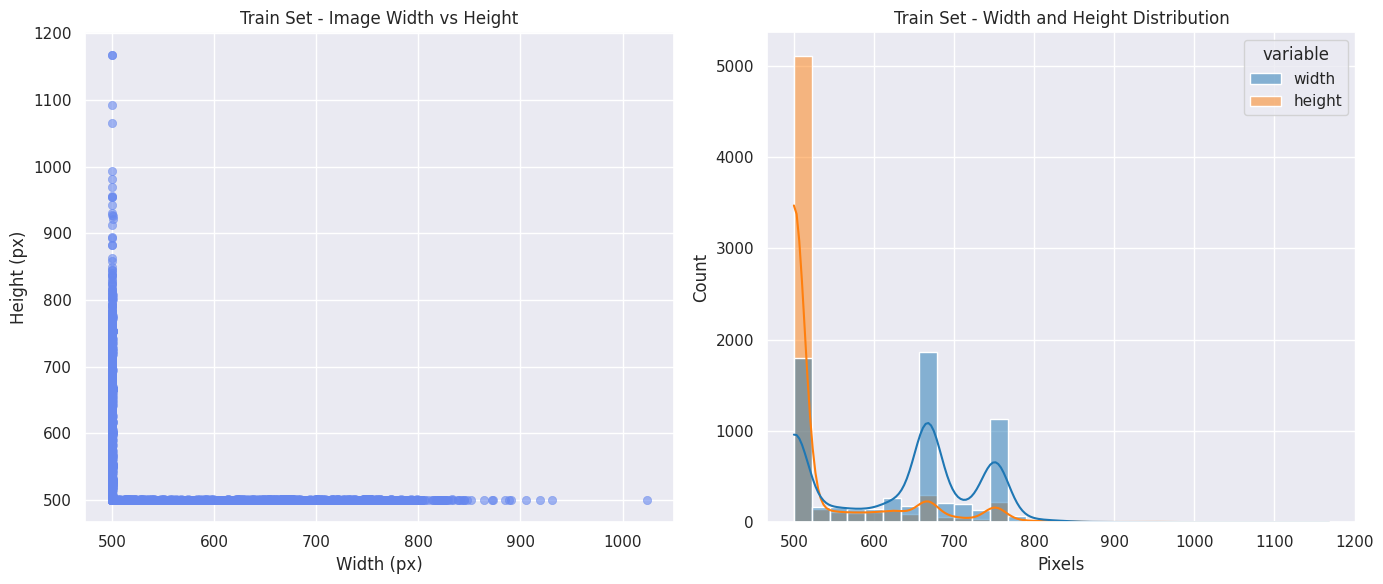

In [7]:
def plot_image_size_distribution(df, dataset_name="", save_path=None):
    plt.figure(figsize=(14, 6))

    # Scatter: Width vs Height
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        data=df,
        x="width",
        y="height",
        alpha=0.6,
        edgecolor=None
    )
    plt.title(f"{dataset_name} - Image Width vs Height")
    plt.xlabel("Width (px)")
    plt.ylabel("Height (px)")

    # Histogram: Width and Height Distribution
    plt.subplot(1, 2, 2)
    sns.histplot(
        data=df[["width", "height"]].melt(),
        x="value",
        hue="variable",
        bins=30,
        kde=True,
        palette="tab10"
    )
    plt.title(f"{dataset_name} - Width and Height Distribution")
    plt.xlabel("Pixels")
    plt.ylabel("Count")

    plt.tight_layout()

    # Save plot if path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        print(f"[✓] Plot saved to {save_path}")

    plt.show()


plot_image_size_distribution(train_stats_df, "Train Set", save_path="ref_plot/")

### *Class Distribution*

[✓] Plot saved to ref_plots/train_class_dist.png


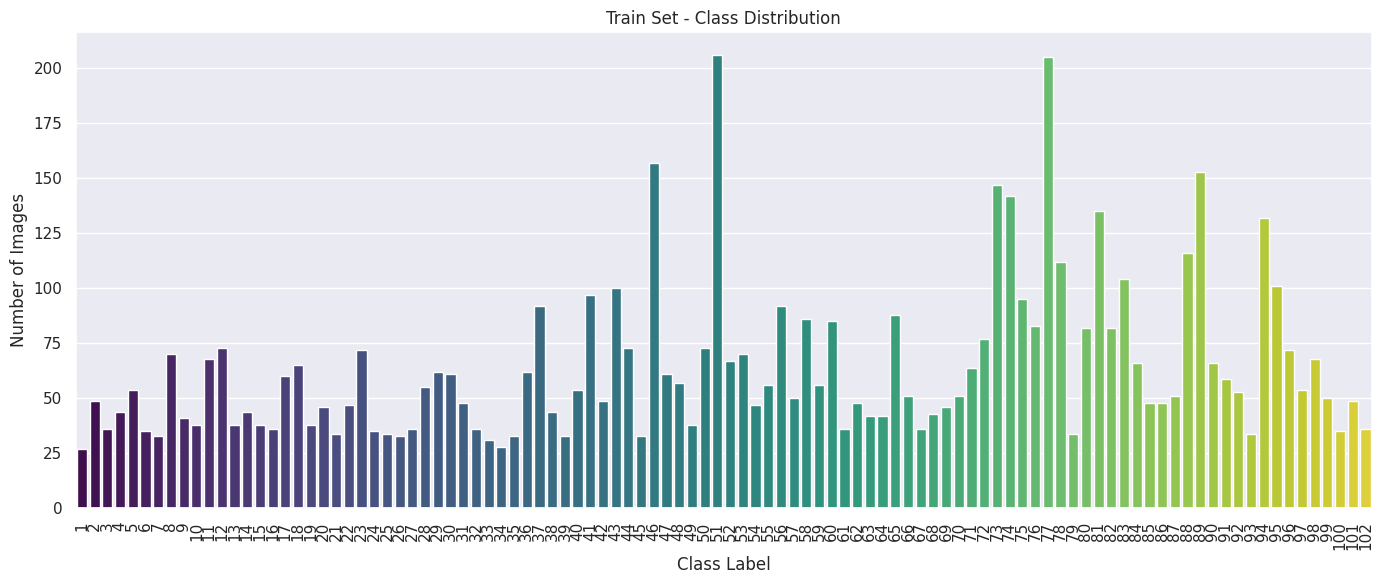

In [ ]:
def plot_class_distribution(df, dataset_name="", save_path=None):
    """
    Plot the distribution of images across classes.

    Parameters:
        df (pd.DataFrame): DataFrame with metadata, including 'class' column.
        dataset_name (str): Name of the dataset (e.g., 'Train Set') for plot title.
        save_path (str, optional): Path to save the plot locally.

    Returns:
        None: Displays and optionally saves the plot.
    """
    plt.figure(figsize=(14, 6))
    sns.countplot(
        data=df,
        x="class",
        order=sorted(df["class"].unique(), key=int),
        palette="viridis"
    )
    plt.title(f"{dataset_name} - Class Distribution")
    plt.xlabel("Class Label")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=90)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        print(f"[✓] Plot saved to {save_path}")

    plt.show()

plot_class_distribution(train_stats_df, "Train Set", save_path="ref_plots/train_class_dist.png")


[✓] Plot saved to ref_plots/valid_class_dist.png


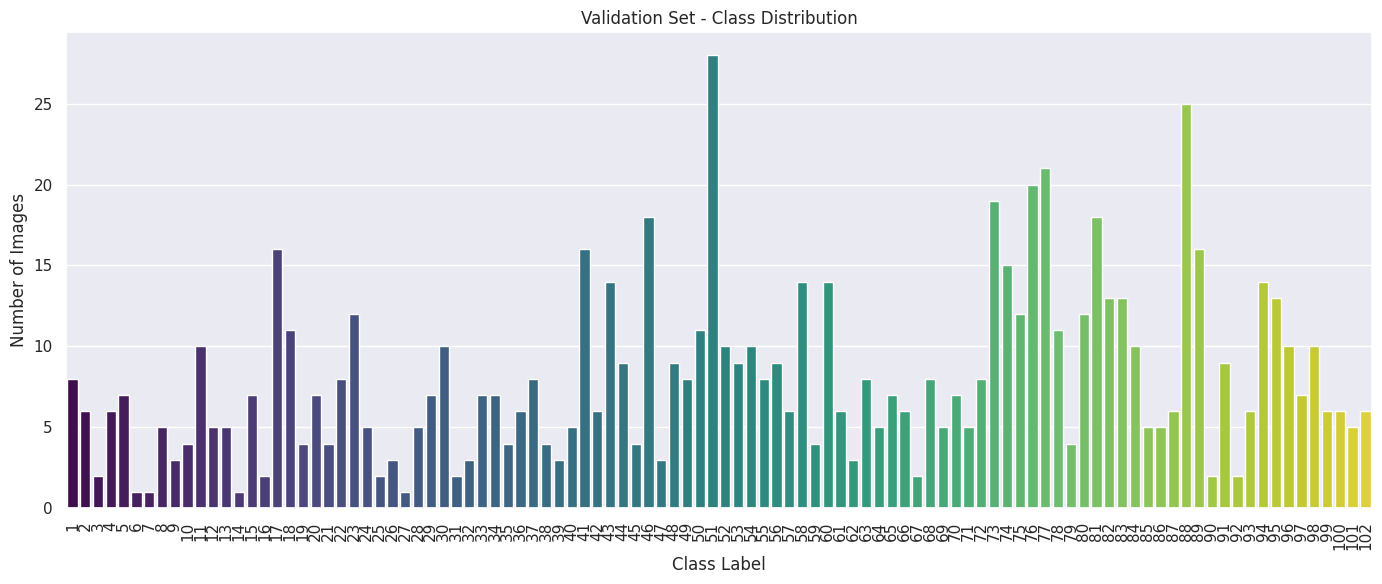

In [63]:
plot_class_distribution(valid_stats_df, "Validation Set", save_path="ref_plots/valid_class_dist.png")

In [64]:
# Calculate min, max, and average number of images per class
train_class_counts = train_stats_df["class"].value_counts()
valid_class_counts = valid_stats_df["class"].value_counts()

print("Train Set Class Stats:")
print(f"Min: {train_class_counts.min()}, Max: {train_class_counts.max()}, Mean: {train_class_counts.mean():.1f}")

print("Validation Set Class Stats:")
print(f"Min: {valid_class_counts.min()}, Max: {valid_class_counts.max()}, Mean: {valid_class_counts.mean():.1f}")

Train Set Class Stats:
Min: 27, Max: 206, Mean: 64.2
Validation Set Class Stats:
Min: 1, Max: 28, Mean: 8.0


### *Aspect Ratio Distribution*

[✓] Plot saved to eda_plots/train_aspect_ratio_dist.png


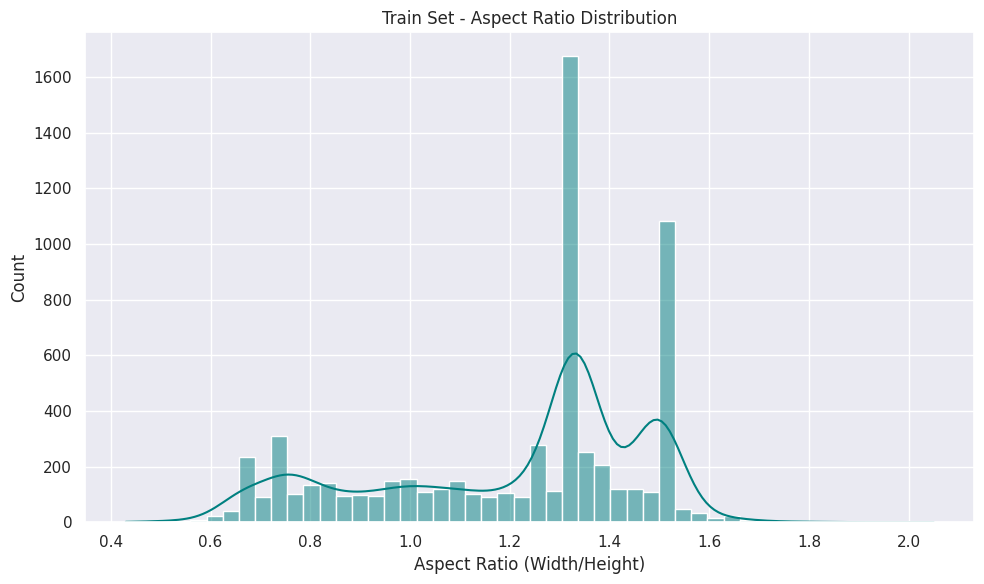

[✓] Plot saved to eda_plots/valid_aspect_ratio_dist.png


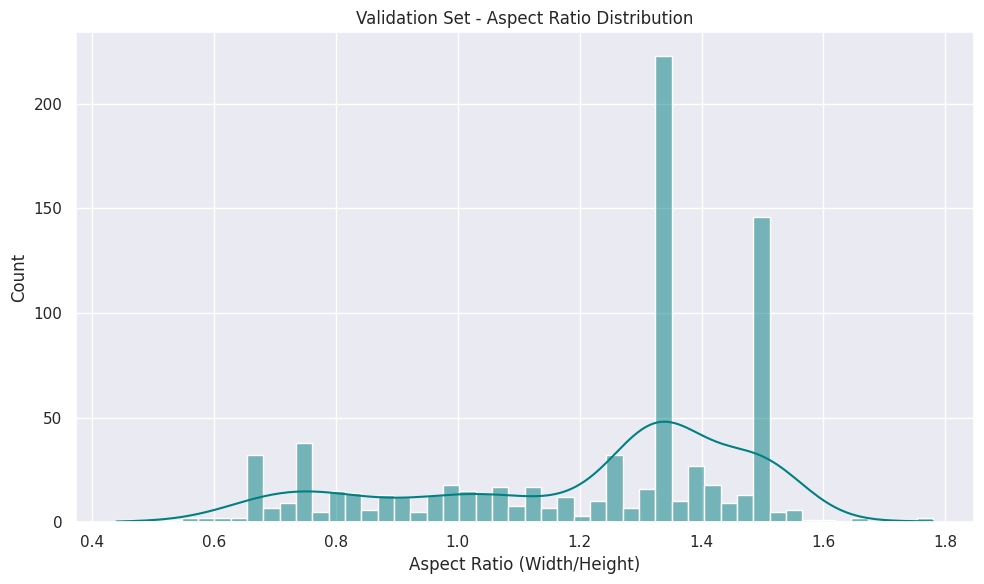

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_aspect_ratio_distribution(df, dataset_name="", save_path=None):
    """
    Plot the distribution of aspect ratios (width/height) for images in the dataset.

    Parameters:
        df (pd.DataFrame): DataFrame with metadata, including 'aspect_ratio' column.
        dataset_name (str): Name of the dataset (e.g., 'Train Set') for plot title.
        save_path (str, optional): Path to save the plot locally.

    Returns:
        None: Displays and optionally saves the plot.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=df,
        x="aspect_ratio",
        bins=50,
        kde=True,
        color="teal"
    )
    plt.title(f"{dataset_name} - Aspect Ratio Distribution")
    plt.xlabel("Aspect Ratio (Width/Height)")
    plt.ylabel("Count")
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        print(f"[✓] Plot saved to {save_path}")

    plt.show()


plot_aspect_ratio_distribution(train_stats_df, "Train Set", save_path="eda_plots/train_aspect_ratio_dist.png")
plot_aspect_ratio_distribution(valid_stats_df, "Validation Set", save_path="eda_plots/valid_aspect_ratio_dist.png")

### *RGB intensity Distribution*

[✓] Plot saved to eda_plots/train_rgb_intensity_dist.png


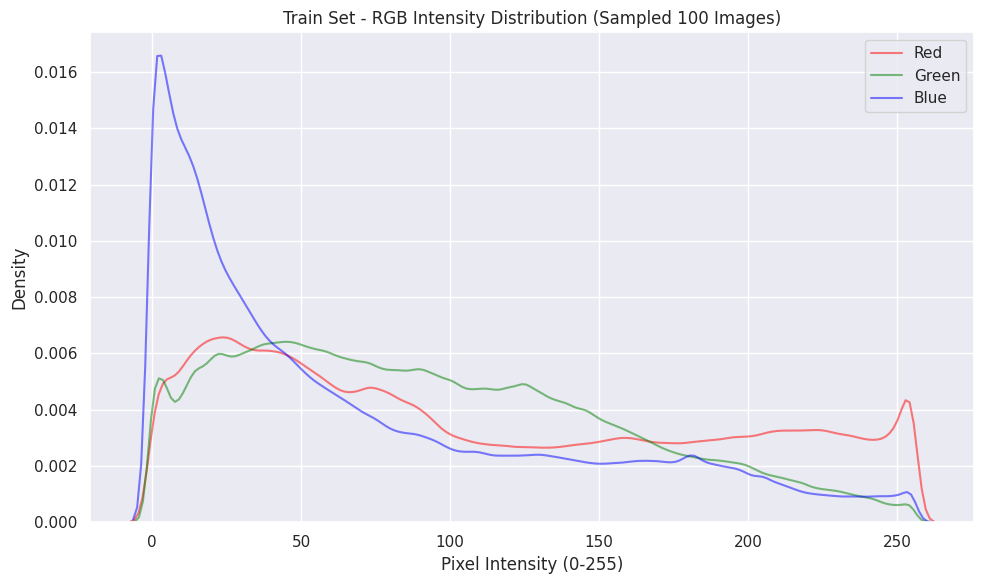

[✓] Plot saved to eda_plots/valid_rgb_intensity_dist.png


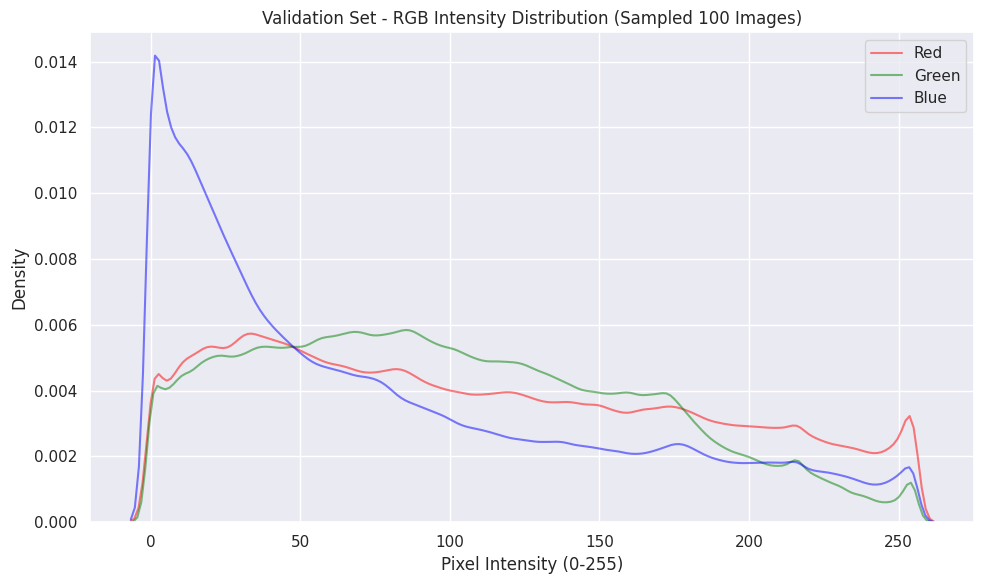

In [ ]:
def plot_rgb_intensity_distribution(df, sample_size=100, dataset_name="", save_path=None):
    """
    Plot the distribution of RGB pixel intensities by sampling images.

    Parameters:
        df (pd.DataFrame): DataFrame with metadata, including 'file_path' column.
        sample_size (int): Number of images to sample for analysis.
        dataset_name (str): Name of the dataset (e.g., 'Train Set') for plot title.
        save_path (str, optional): Path to save the plot locally.

    Returns:
        None: Displays and optionally saves the plot.
    """
    # Sample a subset of images to reduce computation
    sampled_df = df.sample(n=min(sample_size, len(df)), random_state=42)

    # Initialize lists to store pixel intensities for each channel
    red_intensities = []
    green_intensities = []
    blue_intensities = []

    # Process each sampled image
    for _, row in sampled_df.iterrows():
        try:
            img_path = row['file_path']6
            img = Image.open(img_path).convert('RGB')
            img_array = np.array(img)

            # Extract intensities for each channel
            red_intensities.extend(img_array[:, :, 0].flatten())
            green_intensities.extend(img_array[:, :, 1].flatten())
            blue_intensities.extend(img_array[:, :, 2].flatten())

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    # Plot the intensity distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(red_intensities, label='Red', color='red', alpha=0.5)
    sns.kdeplot(green_intensities, label='Green', color='green', alpha=0.5)
    sns.kdeplot(blue_intensities, label='Blue', color='blue', alpha=0.5)

    plt.title(f"{dataset_name} - RGB Intensity Distribution (Sampled {sample_size} Images)")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        print(f"[✓] Plot saved to {save_path}")

    plt.show()


# Usage example
plot_rgb_intensity_distribution(train_stats_df, sample_size=100, dataset_name="Train Set", save_path="eda_plots/train_rgb_intensity_dist.png")
plot_rgb_intensity_distribution(valid_stats_df, sample_size=100, dataset_name="Validation Set", save_path="eda_plots/valid_rgb_intensity_dist.png")

- *These plots show how the brightness (or intensity) of the Red, Green, and Blue colors in your images is spread out, based on a sample of 100 images from each set. The x-axis is the intensity (from 0 = completely dark to 255 = completely bright), and the y-axis shows how common each intensity is (higher means more pixels have that brightness).*

- Lots of Dark Areas: Your images (flowers) likely have dark backgrounds (e.g., leaves, shadows), which is why there are so many dark pixels.
Some Bright Spots: The bright pixels could be the flowers themselves, which stand out against darker backgrounds.
Balanced Colors: Red, Green, and Blue are distributed similarly, so no single color dominates, which is good for consistent feature extraction.
Preprocessing Hint: The heavy skew toward dark pixels suggests you might need to normalize or adjust brightness later to make the model focus on the important parts (e.g., the flowers).

## Visualization

In [14]:
import json

def load_class_mapping(file_path):
    """
    Read a JSON file containing class mappings and return a dictionary of class ID to class name.

    Parameters:
        file_path (str): Path to the JSON file (e.g., 'cat_to_name.json').

    Returns:
        dict: Dictionary mapping class IDs (str) to class names (str).
    """
    try:
        with open(file_path, 'r') as f:
            class_mapping = json.load(f)
        return class_mapping
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return {}
    except json.JSONDecodeError:
        print(f"Error: File {file_path} is not a valid JSON file.")
        return {}
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return {}

# Usage example
class_mapping = load_class_mapping("data/cat_to_name.json")
print(class_mapping)  # Prints the dictionary, e.g., {"1": "pink primrose", "2": "hard-leaved pocket orchid", ...}

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

[✓] Plot saved to eda_plots/train_sample_images.png


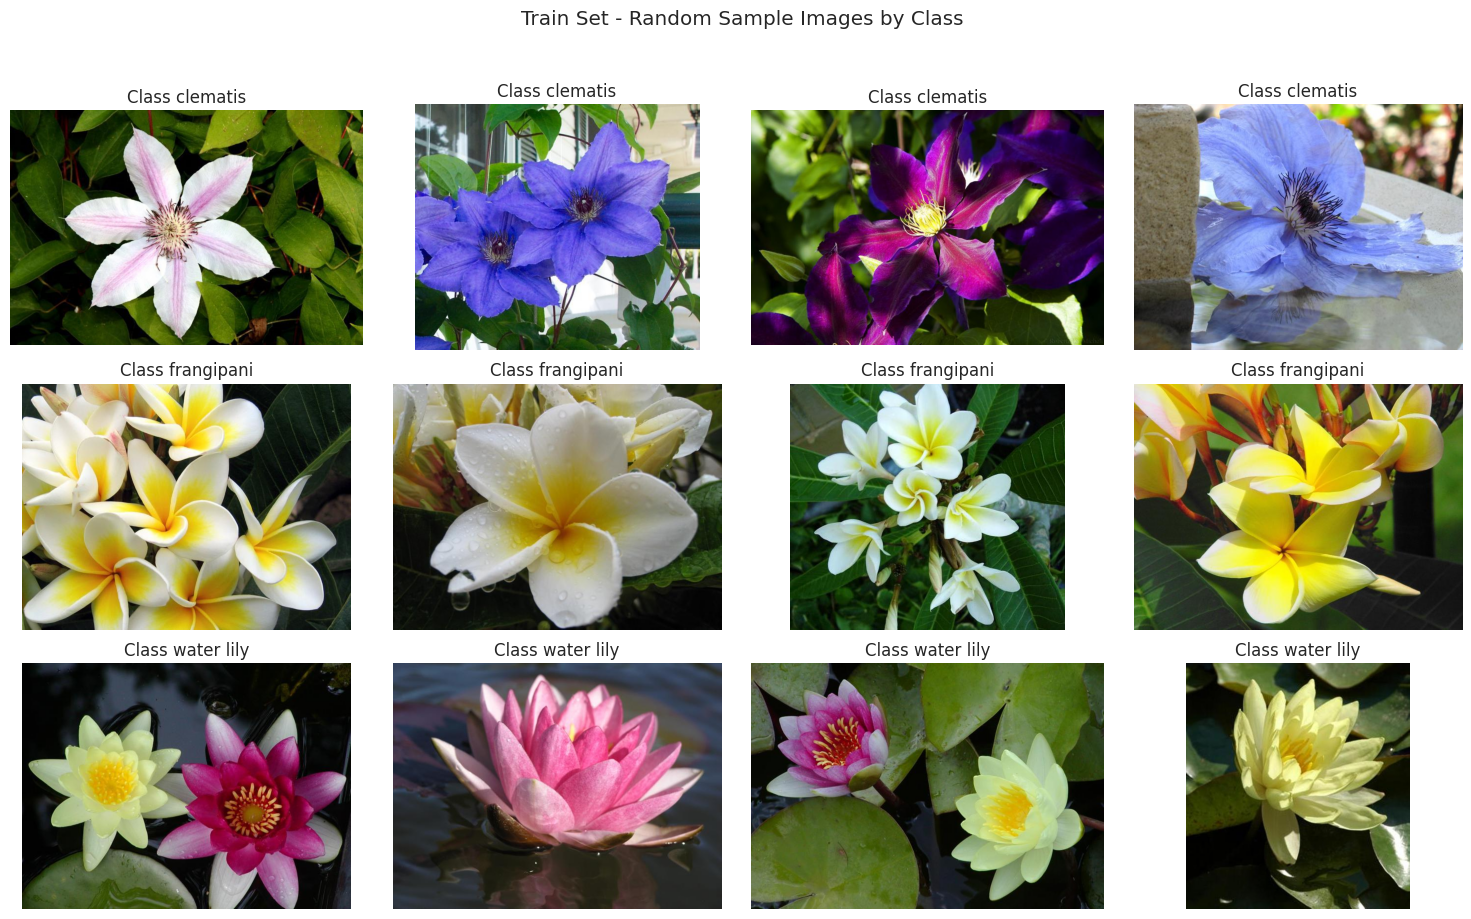

In [15]:
def plot_random_sample_images(df, num_classes=5, images_per_class=3, dataset_name="", save_path=None):
    """
    Plot sample images from randomly selected classes.

    Parameters:
        df (pd.DataFrame): DataFrame with metadata, including 'file_path' and 'class' columns.
        num_classes (int): Number of classes to randomly sample.
        images_per_class (int): Number of images to show per class.
        dataset_name (str): Name of the dataset (e.g., 'Train Set') for plot title.
        save_path (str, optional): Path to save the plot locally.

    Returns:
        None: Displays and optionally saves the plot.
    """
    # Randomly sample classes
    all_classes = df['class'].unique()
    sampled_classes = np.random.choice(all_classes, size=min(num_classes, len(all_classes)), replace=False)

    # Set up the plot
    plt.figure(figsize=(15, num_classes * 3))
    for i, cls in enumerate(sampled_classes):
        # Get random images for this class
        class_images = df[df['class'] == cls]['file_path'].sample(
            n=min(images_per_class, len(df[df['class'] == cls])), 
            random_state=np.random.randint(0, 10000)  # Random seed for reproducibility
        )
        
        for j, img_path in enumerate(class_images):
            try:
                img = Image.open(img_path).convert('RGB')
                plt.subplot(num_classes, images_per_class, i * images_per_class + j + 1)
                plt.imshow(img)
                plt.title(f"Class {class_mapping[cls]}")
                plt.axis('off')
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    plt.suptitle(f"{dataset_name} - Random Sample Images by Class", y=1.02)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        print(f"[✓] Plot saved to {save_path}")

    plt.show()


# Usage example
plot_random_sample_images(train_stats_df, 
                   num_classes=3, 
                   images_per_class=4, 
                   dataset_name="Train Set", 
                   save_path="eda_plots/train_sample_images.png")

## Preprocessing

### *Resize*

- 748x748

Step 1: Convert Images to NumPy Arrays and Preprocess, I’ll provide a function to:


- Load images from your train and validation sets.

- Convert them to NumPy arrays, resize to a uniform size (768x768, based on your ~700-800px preference), normalize pixel values (0-1), and convert to grayscale (to reduce dimensionality, as discussed).

- Flatten the arrays into feature vectors.

- Save the results as DataFrames (train_df, valid_df) with features and class labels, ready for scikit-learn.

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image

def preprocess_images_to_dataframe(df, input_dir, output_dir, target_size=(768, 768), grayscale=True):
    """
    Preprocess images (resize, normalize, flatten) and save as a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame with metadata, including 'file_path' and 'class' columns.
        input_dir (str): Directory containing the original images.
        output_dir (str): Directory to save the output DataFrame (CSV file).
        target_size (tuple): Target width and height for resizing (default: (768, 768)).
        grayscale (bool): If True, convert to grayscale; if False, keep RGB (default: True).

    Returns:
        pd.DataFrame: DataFrame with flattened features and class labels.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Initialize lists for features and labels
    features = []
    labels = []

    for index, row in df.iterrows():
        try:
            # Construct full image path
            img_path = os.path.join(input_dir, row['file_path'])
            if not os.path.exists(img_path):
                print(f"Image not found: {img_path}")
                continue

            # Load and preprocess image
            img = Image.open(img_path).convert('L' if grayscale else 'RGB')
            img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
            img_array = np.array(img_resized) / 255.0  # Normalize to 0-1

            # Flatten the array
            flattened_array = img_array.flatten()
            features.append(flattened_array)
            labels.append(row['class'])

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    # Create DataFrame
    feature_columns = [f'pixel_{i}' for i in range(len(features[0]))]
    result_df = pd.DataFrame(features, columns=feature_columns)
    result_df['class'] = labels

    # Save to CSV
    dataset_name = os.path.basename(input_dir.rstrip('/'))
    csv_path = os.path.join(output_dir, f"{dataset_name}_preprocessed.csv")
    result_df.to_csv(csv_path, index=False)
    print(f"[✓] Saved preprocessed DataFrame to {csv_path}")

    return result_df

# Usage example
train_df = preprocess_images_to_dataframe(
    train_stats_df,
    input_dir="",
    output_dir="processed/",
    target_size=(768, 768),
    grayscale=True
)

valid_df = preprocess_images_to_dataframe(
    valid_stats_df,
    input_dir="",
    output_dir="processed/",
    target_size=(768, 768),
    grayscale=True
)

### *Transforms*

## Training

### *Baseline models*

### *Evaluation*

### *Train after preprocessing*

## Hyperparameter Tuning

### *Random Grid Search*